In [1]:
print("Hello word")

Hello word


# Projet TP DS51 : Web sémantique, ontologies et extraction des connaissances

## Import des librairie

Pour ce projet, nous avons choisis de travailler à l'aide du language python. Ce pour plusieurs raisons, la pricipale étant la facilité et la rapidité du dévelloppement de programe d'intéligence artificel. D'autre pars ce language dispose d'un grand nombre de librairie dédié à l'intéligence artificiel et au machine learning. Nous allons donc commencer par importer les librairies dont nous aurons besoin pour ce projet.

In [2]:
# import the librairies
import numpy as np
import pandas as pd
import os

import PIL
import subprocess
from xml.dom import minidom
from os.path import basename

import torch
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms  import ToTensor, Lambda
from torch import nn
import torch.optim as optims
from torch.utils.data import DataLoader
from PIL import Image


from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt



##  Le datasets

Afin de réaliser ce projet nous allons entrainer notre modèle sur un data set bien éprouvé. Celui qui nous à été proposé est le data set ImageNet Object Localization. Ce  data set à été  utiliser dans le cadre d'un challege visant à obtenir le plus faible taux d'erreur en reconnaissance d'image. Il est composé d'image de plus de 1000 annimaux et mesure un total de 167 Gb. Nous allons donc commencer par télécharger ce dataset depuis le site de kaggle : https://www.kaggle.com/competitions/imagenet-object-localization-challenge/data.

Dans un second temps afin de pouvoir traiter ce dataset dans un temps acceptablen, nous allons en sélectionner uniquement une partie afin de trvailler dessus.

La structure de ce data set est la suivante,le dossier ILSVRC contient un dossier pour chaque  espèce d'annimaux. A l'intérieur de chacun de ces dossier on retrouve différentes images de l'annimal en question. Avec ce data set nous sont aussi fournit des exemple de solutions.



In [37]:
# on vrérifie que le dataset à bien été téléchargé et on renseigne le chemin
#datasetdir = "D:\\UTBM\\DS51\\imagenet-object-localization-challenge"
datasetdir = "C:\\Users\\flocl\\OneDrive - Universite De Technologie De Belfort-Montbeliard\\UTBM\\INFO-04\\DS51\\dataset"

# on renseigne dans des variable les chemin des différent élément
xml_folder= datasetdir + "\\ILSVRC\\Annotations\\CLS-LOC\\train"
train_folder = datasetdir + "\\ILSVRC\\Data\\CLS-LOC\\train"
test_folder = datasetdir + "\\ILSVRC\\Data\\CLS-LOC\\test"
label_map = datasetdir + "\\ILSVRC\\LOC_synset_mapping.txt"

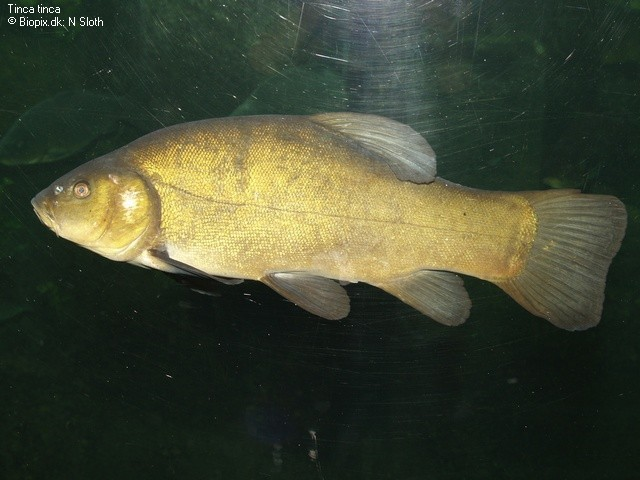

In [38]:
# on test d'afficher une image
PIL.Image.open(train_folder  + "\\n01440764\\n01440764_37.JPEG")

In [39]:
# on récupère les classes des images
os.chdir(train_folder)
subdir = [name for name in os.listdir(".") if os.path.isdir(name)]
subdir

['n01440764',
 'n01443537',
 'n01484850',
 'n01491361',
 'n01494475',
 'n01496331',
 'n01498041',
 'n01514668',
 'n01514859',
 'n01518878']

In [7]:
# on convertit ces numéros de classes en des nom d'èspèce compréhensible  par l'homme
def xmlToTxt(xml_path,f_name,f_w,f_h,f_x,f_y):
    mydoc=minidom.parse(xml_path)
    folder=os.path.basename(os.path.dirname(xml_path))
    filername=os.path.splitext(basename(xml_path))[0]
    width=float(mydoc.getElementsByTagName('width')[0].firstChild.data)
    height=float(mydoc.getElementsByTagName('height')[0].firstChild.data)
    objects=mydoc.getElementsByTagName('object')


    for obj in objects:
        name=obj.getElementsByTagName('name')[0].firstChild.data
        xmin=float(obj.getElementsByTagName('xmin')[0].firstChild.data)
        ymin=float(obj.getElementsByTagName('ymin')[0].firstChild.data)
        xmax=float(obj.getElementsByTagName('xmax')[0].firstChild.data)
        ymax=float(obj.getElementsByTagName('ymax')[0].firstChild.data)
        w=xmax-xmin
        h=ymax-ymin
        x=xmax-w/2
        y=ymin+h/2

        f_name.append(filername)
        f_w.append(w)
        f_h.append(h)
        f_x.append(x)
        f_y.append(y)
    return folder,f_name,f_w,f_h,f_x,f_y

In [19]:
# on crée un dataframe pour chaque image et ça localisation
labels={}
for s in subdir:
    labels[s]=pd.DataFrame()
for target, dirs, files in os.walk(xml_folder):
    filename=None
    f_name=[]
    f_w=[]
    f_h=[]
    f_x=[]
    f_y=[]
    for file in files:
        if file.endswith(".xml"):
            filename,f_name,f_w,f_h,f_x,f_y=xmlToTxt(os.path.join(target, file),f_name,f_w,f_h,f_x,f_y)
    #print(filename)
    if filename != None :
        (labels[filename])['Name']=f_name
        (labels[filename])['width']=f_w
        (labels[filename])['height']=f_h
        (labels[filename])['X']=f_x
        (labels[filename])['Y']=f_y


In [20]:
labels['n01484850'].head()


,Name,dir,width,height,X,Y
0,n01484850_10016,C:\Users\flocl\OneDrive - Universite De Techno...,442.0,250.0,278.0,219.0
1,n01484850_10073,C:\Users\flocl\OneDrive - Universite De Techno...,454.0,132.0,267.0,181.0
2,n01484850_10086,C:\Users\flocl\OneDrive - Universite De Techno...,250.0,115.0,329.0,205.5
3,n01484850_10134,C:\Users\flocl\OneDrive - Universite De Techno...,338.0,222.0,330.0,208.0
4,n01484850_10538,C:\Users\flocl\OneDrive - Universite De Techno...,279.0,127.0,275.5,154.5


In [30]:
# on créer un data frame qui contient les noms des classes et leur numéro
class_names = pd.read_csv(label_map, sep=";", header=None)

In [31]:
class_names.head()

,0,1
0,n01440764,"tench, Tinca tinca"
1,n01443537,"goldfish, Carassius auratus"
2,n01484850,"great white shark, white shark, man-eater, ma..."
3,n01491361,"tiger shark, Galeocerdo cuvieri"
4,n01494475,"hammerhead, hammerhead shark"


In [32]:
def get_class_name(class_code):
    return class_names[class_names[0] == class_code][1].values[0]

def get_class_code(class_name):
    return class_names[class_names[1] == class_name][0].values[0]


In [34]:
get_class_name("n01440764")

' tench, Tinca tinca'

In [11]:
# on adaptre les images pour êtres utilisable par le modèle
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [41]:
# On charge notre data set dans un objet ImageFolder
def load(path):
    dataset = tv.datasets.ImageFolder(root=path,transform = transform)

    train_size = int(0.7 * len(dataset))
    print(train_size)
    test_size = len(dataset) - train_size
    print(test_size)

    train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )

    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )

    return train_loader, test_loader

train_loader, test_loader = load(train_folder)
print(f"train loaders: {train_loader}")

9100
3900
train loaders: <torch.utils.data.dataloader.DataLoader object at 0x000001B41A9FDBE0>


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = tv.models.resnet50(weights=tv.models.ResNet50_Weights.DEFAULT)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

cpu


In [ ]:
loss = []

for epoch, (inputs, labels) in enumerate(train_loader):
    print(f'Epoch {epoch+1}')

    # Move input and label tensors to the device
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero out the optimizer
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    print(f'Outputs: {outputs}')
    loss.append(criterion(outputs, labels))

    # Backward pass
    loss[epoch].backward()
    optimizer.step()

    # Print the loss for every epoch
    print(f'Loss: {loss[epoch].item():.4f}')

Epoch 1


# Le modèle de reconnaissance d'image

Afin de mener à bien la reconnaissance des annimaux dans ce projet nous avons choisis d'utiliser un réseau de neurone à convolution. Nous avons fait ce choix plus plusieurs raison. Premièrement car ce type de modèle est relativement performant pour la tache que nous souhaitons faire, secondement car il est facilement adaptable pour un grand nombre de classe de sortie et efin car il est possible d'avoir des résultat probant même avec un faible temps d'entrainement. Le point noir de ce type de modèle est la néssesité d'avoir un très grand data set d'entré afin d'avoir plusieurs entrée pour chaque espèce. Dans notre cas cela ne pose pas problème car le data set est suffisament grand pour que ce ne soit pas un problème.

Dans le challenge original pour lequel le data set à été concu les deux critère de réussite était de reconnaitre la bonne espèce d'annimal dans l'image mais aussi de réussir à placer une boite autour de cette annimal afin d'en  indiqué la possition. Il était aussi attendu de pouvoir gérer des images contenant plusieurs annimaux potentiellement d'espèce différente. Afin de nous simplifier la tache et des rester sur un  modèle faisable au vu de nos compétence et du temps que nous avons à allouer à ce projet, nous avons fait le choix de mettre de coté la détection de l'emplacement de l'annimal et la prise en compte des images contenant plusieurs animaux. Nous nous contentenrons des images contenant 1 seul annimal et chercherons à trouver l'espèce de l'annimal sur l'image sans en donner son emplacement.

Pour ce faire nous allons utiliser les outils et les modèle de la bibliothèque python torch. PyTorch est une biibliothèque logiciel du language python, elle st open sourse et s'appuie sur  Torch dévellopé par méta. Cette bibliothèque permet d'effectuer des calculs tensoriels qui sont utilisé pour l'apprentissage profond.

In [13]:
train_loader

In [14]:
# on définit les hyper paramètre du modèle
input_size = 256*256
num_classes = 10
learnign_rate = 0.001
batch_size = 16
num_epochs = 2000

In [15]:
# on paramètre le modèle et on le charge
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(input_size, batch_size, 5)
        self.con2 = nn.Conv2d(batch_size, batch_size, 5)
        self.fc1 = nn.Linear(5*5*batch_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.con2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




model = Net(input_size, num_classes)
l = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learnign_rate)

print(model)


Net(
  (conv1): Conv2d(65536, 16, kernel_size=(5, 5), stride=(1, 1))
  (con2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [16]:
for eproch in range(num_epochs):
    y_pred = model(train_loader.requires_grad_())
    loss = l(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print('Epoch {}, loss {}'.format(eproch, loss.item()))


AttributeError: 'DataLoader' object has no attribute 'requires_grad_'

## L'ontologie

### L'ontologie a pour Objectif :

- de décrire les objets du domaine d’un point de vue classification(Par exemple dans le domaine du vivant, la classification scientifique des espèces permettait d’identifier les classes (sous-espèce, espèce, genre,etc.) et les individus (Canis lupus familiaris, Canis lupus, Canis, etc.))et d’un point de morphologique ;

- de caractériser les images labellisées du corpus d’apprentissage. Les propriétés d’une image préciseront :
    - où elle se trouve (URL) ;
    - son format (taille, couleur, etc.) ;
    - ce qu’elle contient.
- L’utilisation  d’un  raisonneur  permettra  d’étendre,  par  inférence,  ce  que  contient  une  image.  Par exemple le fait qu’une image contienne un chien (Canis lupus familiaris) permet d’inférer que cette image
    - contientaussi un Canis lupus, un Canis, un Canidae, etc.
    - contient un museau, des pattes, etc.
    - ne contient pas d’aile, de nageoire, etc.
